In [1]:
import geopandas as gpd
import pandas as pd
import map_apis.get, map_apis.clean, map_apis.plot
import numpy as np
import seaborn as sns
map_apis.RADIUS = 750 # Define the radius of the search

In [2]:
# Get neighborhoods geometry
gdf = gpd.read_file('../../database/neighborhoods.gpkg')

# Get API Coordinates
api_coords = pd.read_csv('grids/grid_centroids.csv')
centroids = api_coords[['api_lat', 'api_lon']].drop_duplicates(keep='first', ignore_index=True)

# Get grids geometry
grids = gpd.read_file('grids/guadalajara_grid.gpkg')
grids = grids.drop_duplicates(subset='geometry')

## Get venues with APIs

Code to get and save the different types of venues using OSM and Foursquare
APIs.

In [ ]:
# --- OpenStreetMap (OSM) ---------------------------------------------------#
# Tags
tags ={
    'parks':{
        'leisure': ['park', 'garden'],
        'natural': 'wood',
        'landuse': 'forest',
        'landcover': 'trees'
    },
    'schools': {'amenity': ['school', 'university', 'kindergarten', 'college']},
    'public_transport': {
        'highway': 'bus_stop',
        'public_transport': 'station',
        'name': ['Macrobús', 'MiBici'],
        'railway': 'station',
        'station': 'light_rail',
        'amenity': 'bicycle_rental',
    },
    'police_stations': {'amenity': 'police'},
    'hospitals': {'amenity': 'hospital'},
    'malls': {'shop': 'mall', 'building': 'mall'}
}
venue_type = 'parks'  # 'parks' | 'schools' | 'public_transport' |
                          # 'police_stations' | 'hospitals' | 'malls'

osm_df = map_apis.get.get_osm_venues(grids, tags=tags[venue_type])
osm_df.to_file(f'../../database/venues_gpkg/{venue_type}.gpkg', driver="GPKG", index=False)

  9%|▊         | 47/546 [00:05<01:00,  8.20it/s]


In [ ]:
# --- Foursquare ------------------------------------------------------------#
categ_codes = {
    'retail': ['17000'],  # Retail
    'health': ['15000'],  # Health and medicine
    'education': ['12009'],  # Community and Government > Education
    'sport': ['18021'],  # Sports and Recreation > Gym and Studio
}
categs = 'sport'  # 'retail' | 'health' | 'education' | 'sport'
fsq_df = map_apis.get.get_fsq_venues(categories=categ_codes[categs], centroids=centroids)
fsq_df.to_csv(f'./venues_csv/{categs}_venues.txt', sep='\t', index=False)

grids:   0%|          | 0/546 [00:00<?, ?it/s]

grids: 100%|██████████| 546/546 [47:47<00:00,  5.25s/it]  


In [ ]:
# --- Google Maps (text search) ---------------------------------------------#
queries = [
    "escuela primaria",
    "secundaria",
    "preparatoria",
    "universidad",    
    "preescolar",
]
goo_df = map_apis.get.get_google_text_venues(queries=queries, centroids=centroids)
goo_df.to_csv('./venues_csv/google_education.txt', sep='\t')

Searching "preescolar": 100%|██████████| 546/546 [15:18<00:00,  1.68s/it]


## Map Plots

Code to plot the unprocessed venues.

In [5]:
# Import
venue_type = 'parks'  # 'parks' | 'schools' | 'public_transport' |
                    # 'police_stations' | 'hospitals' | 'malls'

gdf_venues = gpd.read_file(f'../../database/venues_gpkg/{venue_type}.gpkg')

categs = 'retail'  # 'retail' | 'health' | 'education' | 'sport'
df_venues = pd.read_csv(f'./venues_csv/{categs}_venues.txt', sep='\t')

In [6]:
# Filter
gdf_layer = gdf_venues.drop_duplicates(keep='first')
df_layer = df_venues[df_venues['name'].str.lower().str.contains('oxxo')]

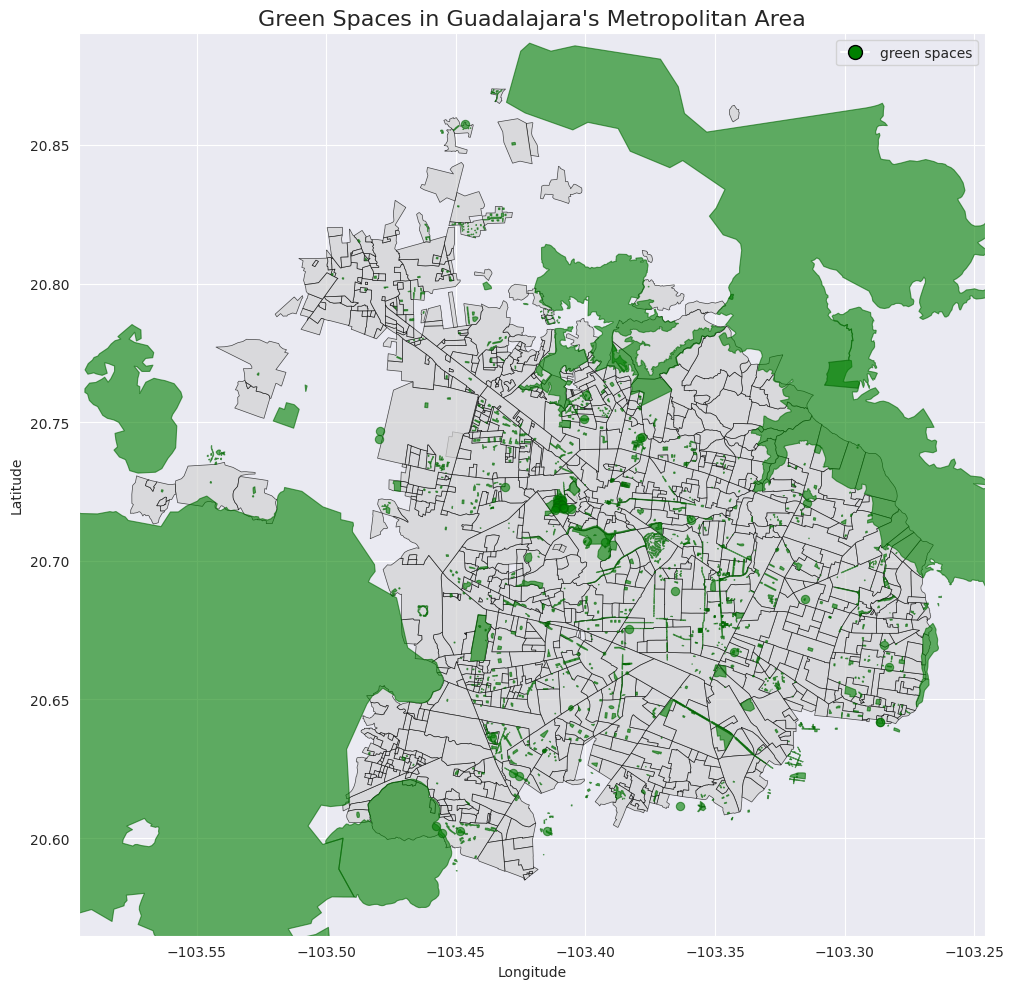

In [7]:
sns.set_style("darkgrid")
map_apis.plot.plot_gdf_over_gdf(
    gdf_base=gdf,
    gdf_layer=gdf_layer,
    title='Green Spaces in Guadalajara\'s Metropolitan Area',
    legend_label='green spaces',
    save=False,
    layer_color='green',
    layer_edgecolor='darkgreen',
    clip_to_base=True
    )

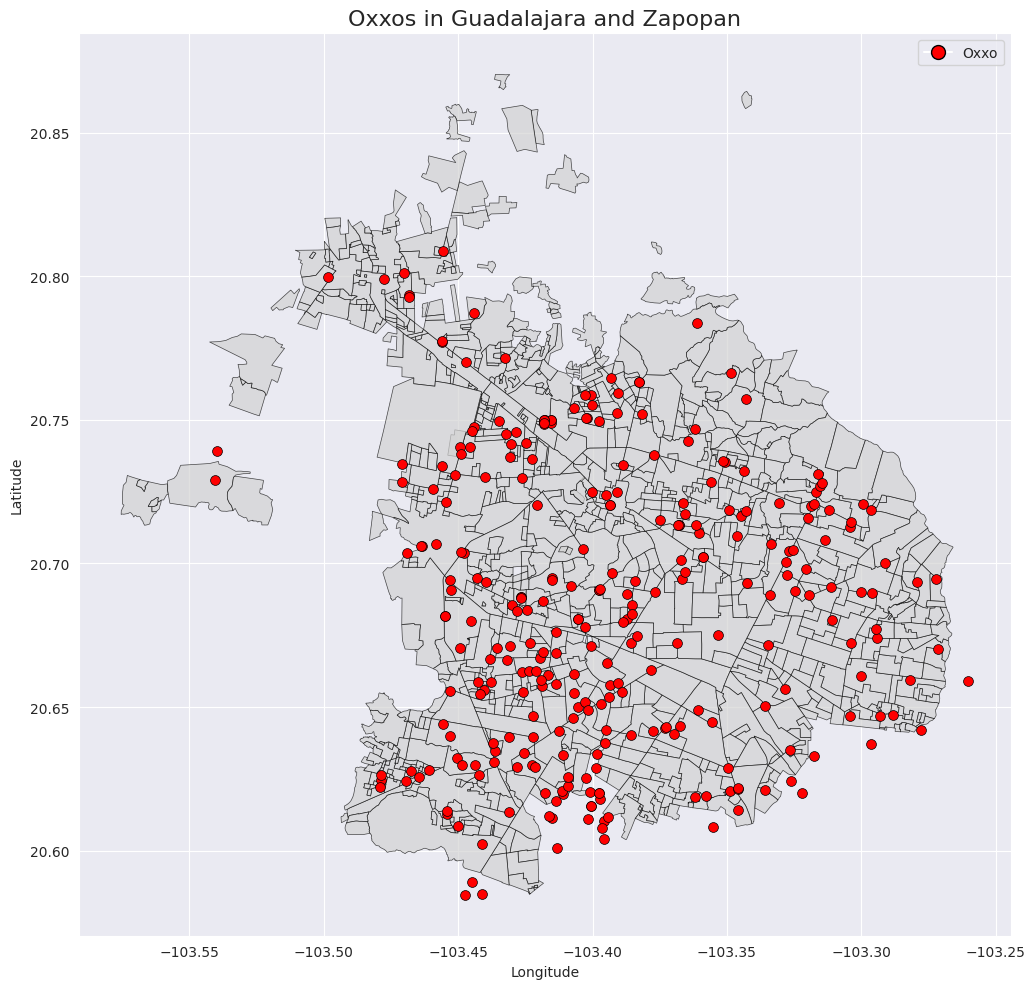

In [8]:
map_apis.plot.plot_df_over_gdf(
    gdf_base=gdf,
    df_layer=df_layer,
    title='Oxxos in Guadalajara and Zapopan',
    legend_label='Oxxo',
    save=False,
    layer_color='red',
    layer_edgecolor='black'
)

## Data preprocessing

Merge gpkg files

In [3]:
venue_cats = ['parks', 'public_transport', 'police_stations', 'hospitals', 'malls']
osm_df = gpd.GeoDataFrame()
for cat in venue_cats:
    raw_df = gpd.read_file(f'../../database/venues_gpkg/{cat}.gpkg')
    prc_df = map_apis.clean.process_osm(gdf=raw_df, category=cat)
    osm_df = pd.concat([osm_df, prc_df], ignore_index=True)
osm_df['source'] = 'OpenStreetMap'

In [4]:
fsq_cats = ['sport', 'retail', 'health']
fsq_df = gpd.GeoDataFrame()
for cat in fsq_cats:
    raw_df = pd.read_csv(f'./venues_csv/{cat}_venues.txt', sep='\t')
    prc_df = map_apis.clean.process_fsq(df=raw_df, category=cat)
    fsq_df = pd.concat([fsq_df, prc_df], ignore_index=True)
fsq_df['category'] = fsq_df['category'].str.lower()
fsq_df['subcategory'] = fsq_df['subcategory'].str.lower()
fsq_df['source'] = 'FourSquare'

In [5]:
goog_cats = ['highschools', 'preschools', 'primary_schools', 'secondary_schools', 'universities']
goog_df = gpd.GeoDataFrame()
for cat in goog_cats:
    raw_df = pd.read_csv(f'./venues_csv/{cat}.txt', sep='\t')
    prc_df = map_apis.clean.process_goog(df=raw_df, category=cat)
    goog_df = pd.concat([goog_df, prc_df], ignore_index=True)
goog_df['category'] = goog_df['category'].str.lower()
goog_df['subcategory'] = goog_df['subcategory'].str.lower()
goog_df['source'] = 'GoogleMaps'

In [ ]:
df_venues = pd.concat([osm_df, fsq_df, goog_df], ignore_index=True)  # concatenate
df_venues = df_venues.drop_duplicates()  # drop duplicates
df_venues = df_venues[df_venues.geometry.type != 'LineString']  # remove LineStrings
df_venues.to_file('../../database/venues.gpkg', driver="GPKG", index=False)  # export

In [ ]:
# show summary table
df_venues[['source', 'category', 'subcategory', 'geometry']].groupby(['source', 'category', 'subcategory']).count().to_clipboard()

## Creating plots

In [6]:
sns.set_style("darkgrid")
import matplotlib.pyplot as plt

def plot_cat(
        venues_df:gpd.GeoDataFrame,
        category:str,
        column:str,
        category_colors:dict,
        save:bool=False,
        savepath:str='.',
        make_plural:bool=True,
    ) -> None:
    '''
    Creates plot of a given category coloring by other column (commonly
    subcategory)
    '''
    temp = venues_df[venues_df['category'] == category]  # filter to category only

    fig, ax = plt.subplots(figsize=(12, 10))  # create plot

    # neighborhoods plot
    gdf.plot(
        ax=ax,
        color='lightgray',
        edgecolor='black',
        linewidth=0.5,
        alpha=0.7
        )
    # add subplots
    for name, color in category_colors.items():
        temp[temp[column] == name].plot(
            ax=ax,
            color=color,
            label=name,
            edgecolor='black'
        )
    # add plot attributes
    plt.legend()
    if make_plural:
        plt.title(f'{''.join(category.split('_')).title()}s in Guadalajara')
    else:
        plt.title(f'{''.join(category.split('_')).title()} in Guadalajara')

    # save
    if save:
        filename = f'{savepath}/{'_'.join(category.split())}'
        if make_plural:
            plt.savefig(f'{filename}s.png')
        else:
            plt.savefig(f'{filename}s.png')

    plt.show()

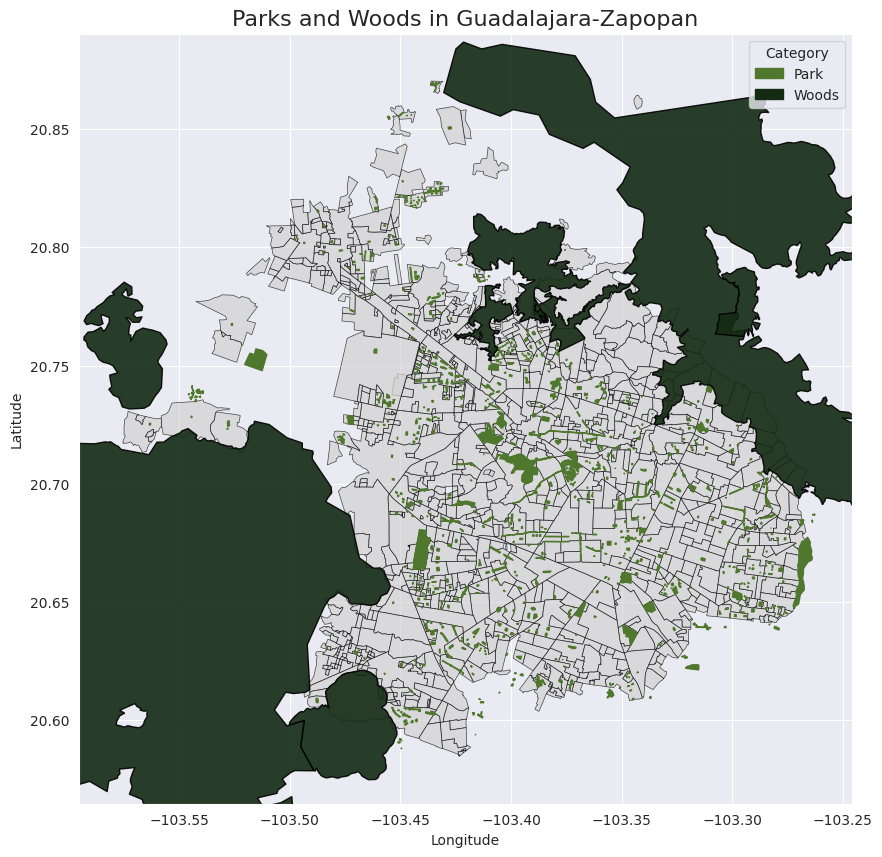

In [29]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(12, 10))  # create plot

# neighborhoods plot
gdf.plot(
    ax=ax,
    color='lightgray',
    edgecolor='black',
    linewidth=0.5,
    alpha=0.7
    )
df_venues[df_venues['category'] == 'park'].plot(
    ax=ax,
    color='#4f772d',
    label='park',
    edgecolor='#4f772d'
)
df_venues[df_venues['category'] == 'woods'].plot(
    ax=ax,
    color='#132a13',
    label='park',
    edgecolor='black',
    alpha=0.9
)

# Create manual legend
legend_handles = [
    mpatches.Patch(color='#4f772d', label='Park'),
    mpatches.Patch(color='#132a13', label='Woods')
]
ax.legend(handles=legend_handles, title='Category')

expand_bounds = 0.02  # CRS units
minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx - expand_bounds, maxx + expand_bounds)
ax.set_ylim(miny - expand_bounds, maxy + expand_bounds)
plt.title('Parks and Woods in Guadalajara-Zapopan', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

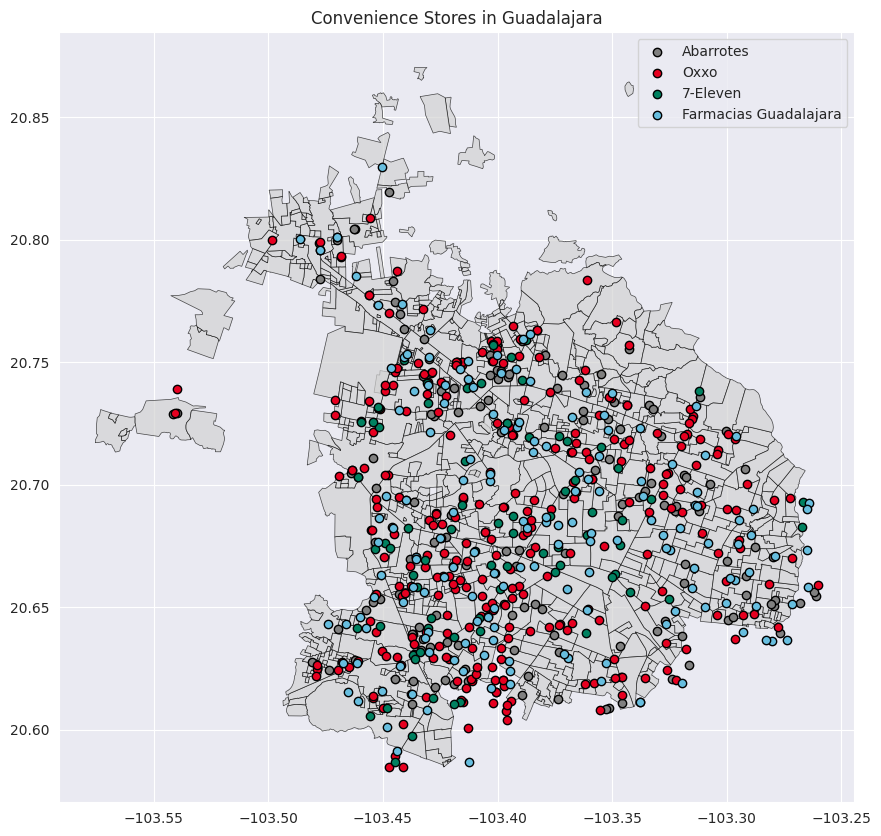

In [25]:
folderpath = '/home/gus/Documents/github_repos/blog/static/images/masters_thesis/venues_table/carousel'
name_colors = {
    'Abarrotes': 'gray',
    'Oxxo': '#e70020',
    '7-Eleven': '#008160',
    'Farmacias Guadalajara': '#67bedf',
}
plot_cat(
    venues_df=df_venues,
    category='convenience store',
    column='name',
    category_colors=name_colors,
    save=True,
    savepath=folderpath
)

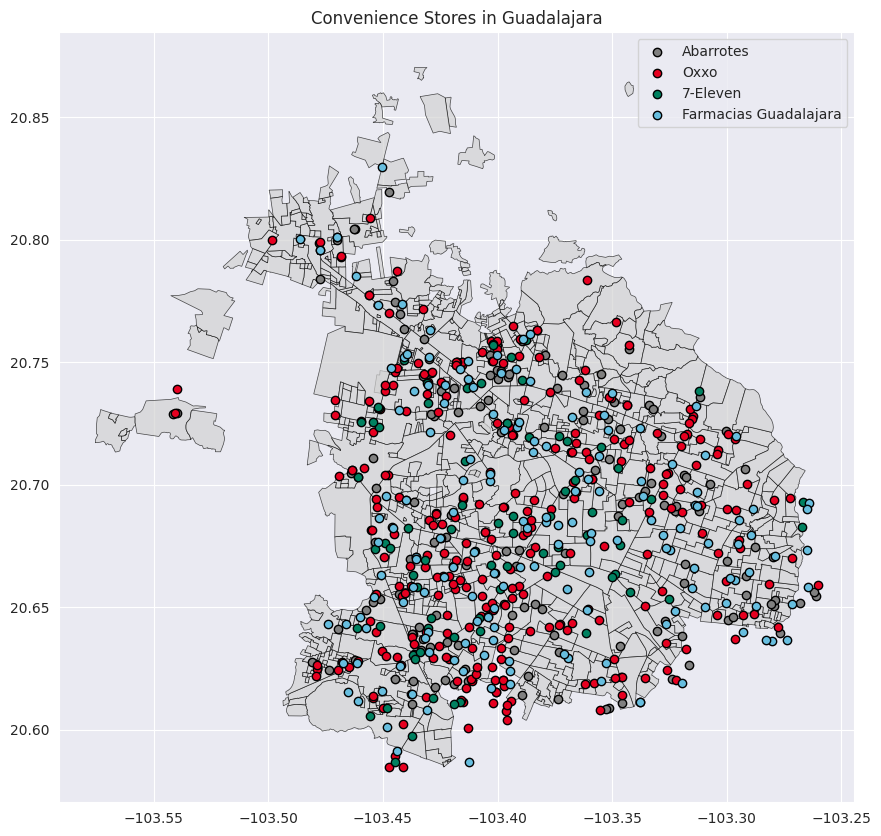

In [11]:
folderpath = '/home/gus/Documents/github_repos/blog/static/images/masters_thesis/venues_table/carousel'
name_colors = {
    'Abarrotes': 'gray',
    'Oxxo': '#e70020',
    '7-Eleven': '#008160',
    'Farmacias Guadalajara': '#67bedf',
}
plot_cat(
    venues_df=df_venues,
    category='convenience store',
    column='name',
    category_colors=name_colors,
    save=True,
    savepath=folderpath
)

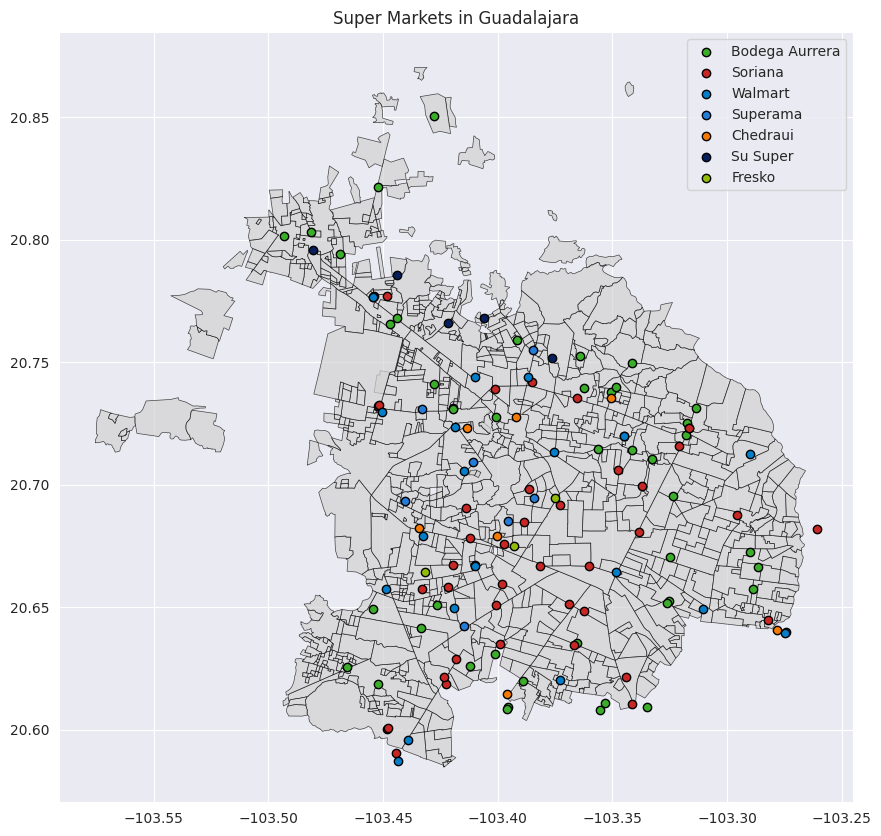

In [13]:
name_colors = {
    'Bodega Aurrera':'#3aad2a',
    'Soriana':'#c72725',
    'Walmart':'#047ec9',
    'Superama':'#247cd6',
    'Chedraui':'#f57a03',
    'Su Super':'#071f5b',
    'Fresko':'#91bc08',
}
plot_cat(
    venues_df=df_venues,
    category='super market',
    column='name',
    category_colors=name_colors,
    save=True,
    savepath=folderpath
)

In [22]:
df_venues[df_venues['source']=='FourSquare']['subcategory'].value_counts()
#df_venues['category'].unique()

subcategory
college                           2468
medical specialist                2171
workout studio                     579
gym                                557
convenience store                  535
health clinic                      484
elementary school                  458
hospital                           429
drugstore                          346
veterinarian                       327
higher education                   268
other sports                       264
other health services              221
preschool                          201
laboratory                         195
abarrotes                          149
super market                       130
psychologist                       114
high school                        113
liquor store                       102
middle school                       88
alternative medicine                72
department store                    52
sports club                         45
daycare                             40
clothing stor

/tmp/ipykernel_25680/1037542244.py:39: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


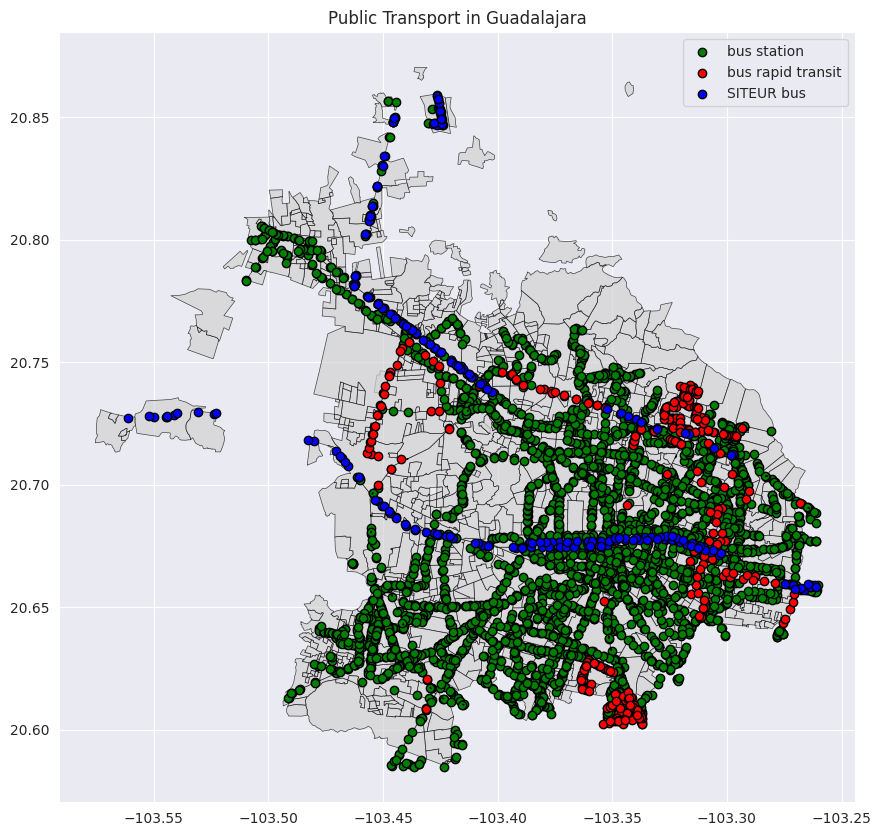

In [104]:
name_colors = {
    'bus station': 'green',
    'bus rapid transit': 'red',
    'SITEUR bus': 'blue',
    #'light rail train': 'yellow',
}

plot_cat(
    venues_df=df_venues,
    category='public transport',
    column='subcategory',
    category_colors=name_colors,
    save=True,
    savepath=folderpath,
    make_plural=False,
    show=False
)

In [24]:
df_venues[(df_venues['subcategory']=='college')&(df_venues['source']=='FourSquare')]#.geometry.type.value_counts()

category subcategory                                               name  \
12402  college     college  "Vive Bolivia" Centro de Idiomas y Culturas Bo...   
12403  college     college                                                 1A   
12404  college     college                                        1ro “B” CSJ   
12405  college     college              2do. Foro Regional de Servicio Social   
12406  college     college                                           300s HAL   
...        ...         ...                                                ...   
16030  college     college                                 prepa IDEM ceneval   
16033  college     college                                             sala a   
16034  college     college                        sala de usos multiples ENSJ   
16037  college     college                                       Áreas verdes   
16038  college     college                          Único (ÚNICO Universidad)   

      operator                     geometry      source  
12402      NaN  POINT (-103.38162 20.70949)  FourSquare  
12403      NaN  POINT (-103.42386 20.72335)  FourSquare  
12404      NaN  POINT (-103.42382 20.72333)  FourSquare  
12405      NaN  POINT (-103.41969 20.65982)  FourSquare  
12406      NaN  POINT (-103.41159 20.75833)  FourSquare  
...        ...                          ...         ...  
16030      NaN  POINT (-103.40607 20.67535)  FourSquare  
16033      NaN  POINT (-103.32547 20.65412)  FourSquare  
16034      NaN  POINT (-103.33524 20.71198)  FourSquare  
16037      NaN   POINT (-103.32954 20.6927)  FourSquare  
16038      NaN  POINT (-103.42168 20.70505)  FourSquare  

[2468 rows x 6 columns]

In [ ]:
import folium
import folium.plugins

curr_ven = df_layer
center_lat, center_lon = curr_ven['lat'].mean(), curr_ven['lon'].mean()
# Convert venue DataFrame to GeoDataFrame
gdf_venues = gpd.GeoDataFrame(
    curr_ven,
    geometry=gpd.points_from_xy(curr_ven.lon, curr_ven.lat),
    crs="EPSG:4326"  # WGS84 coordinate reference system
)

m = folium.Map(location=[center_lat, center_lon], zoom_start=13, tiles='cartodbpositron')

# Add neighborhoods as polygons with tooltips
folium.GeoJson(
    gdf,
    name='neighborhood',
    style_function=lambda feature: {
        'fillColor': '#ffff00',
        'color': '#000000',
        'weight': 1,
        'fillOpacity': 0.2
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['neighborhood'],  # adjust to your neighborhood attribute fields
        aliases=['neighborhood: '],
        localize=True
    )
).add_to(m)

# Add venues as markers with clustering
marker_cluster = folium.plugins.MarkerCluster().add_to(m)

for idx, row in gdf_venues.iterrows():
    popup_text = f"<b>{row['name']}</b><br>Category: {row['category']}"
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=popup_text,
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(marker_cluster)

# Add layer control to toggle layers
folium.LayerControl().add_to(m)

# Display the map
#m.save('./ex.html')
m

In [48]:
import folium
import folium.plugins
import geopandas as gpd

# Filter to Point geometries only
gdf_venues = gdf_layer[gdf_layer.geometry.type == 'Point'].copy()

# Compute map center
center_lat = gdf_venues.geometry.y.mean()
center_lon = gdf_venues.geometry.x.mean()

gdf_venues = gdf_layer.copy()
fields_to_show = ['name']

# Create folium map
m = folium.Map(location=[center_lat, center_lon], zoom_start=13, tiles='cartodbpositron')

# Add neighborhoods as GeoJSON
folium.GeoJson(
    gdf,
    name='neighborhood',
    style_function=lambda feature: {
        #'fillColor': '#ffff00',
        'color': '#000000',
        'weight': 1,
        'fillOpacity': 0.2
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['neighborhood'],
        aliases=['Neighborhood: '],
        localize=True
    )
).add_to(m)

folium.GeoJson(
    gdf_venues,
    name='malls',
    style_function=lambda feature: {
        'fillColor': 'red',
        'color': '#000000',
        'weight': 1,
        'fillOpacity': 0.9
    },
    tooltip=folium.GeoJsonTooltip(
        fields=fields_to_show,
        aliases=[f'{field.capitalize()} :' for field in fields_to_show],
        localize=True,
    )
).add_to(m)

for idx, row in gdf_venues.iterrows():
    label = f"{row['name']} ({idx})"  # Customize fields as needed
    folium.map.Marker(
        [row.geometry.centroid.y, row.geometry.centroid.x],
        icon=folium.DivIcon(html=f"""<div style="font-size: 10pt; color: black; ">{label}</div>""")
    ).add_to(m)

# for categ in df_venues['category'].unique():

#     folium.GeoJson(
#         df_venues[(df_venues['category']==categ)],
#         name=categ,
#         style_function=lambda feature: {
#             'fillColor': 'darkgreen',
#             'color': '#000000',
#             'weight': 1,
#             'fillOpacity': 0.2
#         },
#         tooltip=folium.GeoJsonTooltip(
#             fields=['category', 'subcategory', 'name'],
#             aliases=['category: ', 'subcategory: ', 'name: '],
#             localize=True
#         )
#     ).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)
m.save('./ex2.html')